# Evaluation of lazy serialization with serverless-sim
In this document, we evaluate the effect of different serialization policies on various benchmarks using dask. 
* **Serialization to external cache (sync-serialization)**: in this model the dask-task *(A)* waits for its output to be serialized before sending the completion back to the scheduler. If another task *(B)*, which depends on the output of *(A)*, is scheduled on the same node as *(A)*, it should first deserializae the output of *(A)* before running any computation. Throughout this evaluation we refer to this model as 
* **Serialization to external cache with keeping a copy inside  process memory cache (sync-serialization-with-proc-cache)**: this model is similar to *sync-serialization*, except that we keep a copy of the data in the process memory, and when *(B)* reads the output of *(A)* in the same node, it is servered from the python process memory. Thus, we are not paying any de-serialization delay. This model assumes that the dependet task *(B)* is executed on the same process as its parent *(A)*.
* **Lazy serialization to external cache (lazy-serialization)**: In this model, the dask-task *(A)* issues output serialization asynchroneously, keep a copy of data in python process memory. When *(B)* scheduled on the same node as its parent task *(A)*, the input data to *(B)* is servered from the python process memory. Thus, we are not paying any de-serialization delay. When *(B)* is scheduled on another node that its parent task *(A)*, it should wait for the output of *(A)* to be serialized in the cache.  

In [570]:
#!/usr/bin/python3
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import pandas as pd
import numpy as np
import math
import json
from os import listdir
from os.path import isfile, join
import sys
import glob
import graph_tool.all as gt
from datetime import datetime, date, time
import ast
import os

sns.set(color_codes=True)

def format_xticks(x, pos=None):
    return x

def format_yticks_right(y, pos=None):
    return y

sns.set_style("whitegrid")
plt.rc('font', family='serif')

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})


%matplotlib inline

policy_name_map = {'syncwdeser': 'sync-serialization',
           'syncnodeser': 'Sync-serialization-with-proc-cache', 
           'lazy': 'Lazy-serialization'}


In [632]:
path = '/local0/serverless-sim/results/'
log_files = [os.path.join(path, f) for f in os.listdir(path)\
             if os.path.isfile(os.path.join(path, f)) and f.endswith('.log')]

statistics = []
dataframes = []
serialization_delay = []
for f in log_files:
    benchmark, serialization, scheduling, _ = f.rsplit('/', 1)[1].split('.')
    benchmark = benchmark.rsplit('_', 1)[0] 
    #print(benchmark, serialization, scheduling)
    with open(f, 'r') as fd:
        logs = ast.literal_eval(fd.read())
        
        ds = pd.DataFrame(logs['tasks'])
        ds['total_read'] = ds['remote_read'] + ds['local_read']
        ds['ser_delay'] = (ds['serialization_time'] + ds['wait_for_serialization'])
        ds['ser_tasktime'] = (ds['serialization_time'] + ds['wait_for_serialization'])/ds['task_endtoend_delay']
        ds['pser_tasktime'] = 100*(ds['serialization_time'] + ds['wait_for_serialization'])/ds['task_endtoend_delay']
        ds['task_no_sertime'] = ds['task_endtoend_delay'] - ds['ser_delay']
        ds['deser_tasktime'] = ds['deserialization_time']/ds['task_endtoend_delay']
        ds['total_ser_delay'] = ds['serialization_time'] + ds['wait_for_serialization'] + ds['deserialization_time']
        ds['pserdeser_tasktime'] = 100*(ds['total_ser_delay'])/ds['task_endtoend_delay']
        ds['task_no_serdesertime'] = ds['task_endtoend_delay'] - ds['ser_delay'] - ds['deserialization_time']
        ds[['benchmark', 'serialization_policy', 'scheduling_policy']] = benchmark, serialization, scheduling
        
        
        dataframes.append(ds)
        
        del logs['tasks']
        logs['benchmark'] = benchmark
        logs['serialization_policy'] = serialization
        logs['scheduling_policy'] = scheduling
        statistics.append(logs)
        
    #break
dt = pd.concat(dataframes)
df = pd.DataFrame(statistics).sort_values(by='benchmark').reset_index(drop=True)

## Benchmark statistics evaluation 

In [626]:
dt.head(3)

,name,transfer,cpu_time,remote_read,local_read,fetch_time,deserialization_time,serialization_time,task_endtoend_delay,write,...,ser_delay,ser_tasktime,pser_tasktime,task_no_sertime,deser_tasktime,total_ser_delay,pserdeser_tasktime,benchmark,serialization_policy,scheduling_policy
0,('normal-_predict-4973e05310a631f5866ba4c4c527...,0.0,94.607617,0,0,0.000000,0.000000,1.344218,95.951835,40000000,...,1.344218,0.014009,1.400930,94.607617,0.000000,1.344218,1.400930,svm_parallelization_1a899e63,syncwdeser,chain_color
1,('normal-_predict-4973e05310a631f5866ba4c4c527...,0.0,94.817226,0,0,0.000000,0.000000,1.344218,96.161444,40000000,...,1.344218,0.013979,1.397876,94.817226,0.000000,1.344218,1.397876,svm_parallelization_1a899e63,syncwdeser,chain_color
2,"('_predict-4973e05310a631f5866ba4c4c5279b4e', 6)",0.0,0.000018,0,40000000,0.048454,0.048454,1.344218,1.392690,40000000,...,1.344218,0.965196,96.519560,0.048472,0.034792,1.392672,99.998733,svm_parallelization_1a899e63,syncwdeser,chain_color


## Execution time evaluation

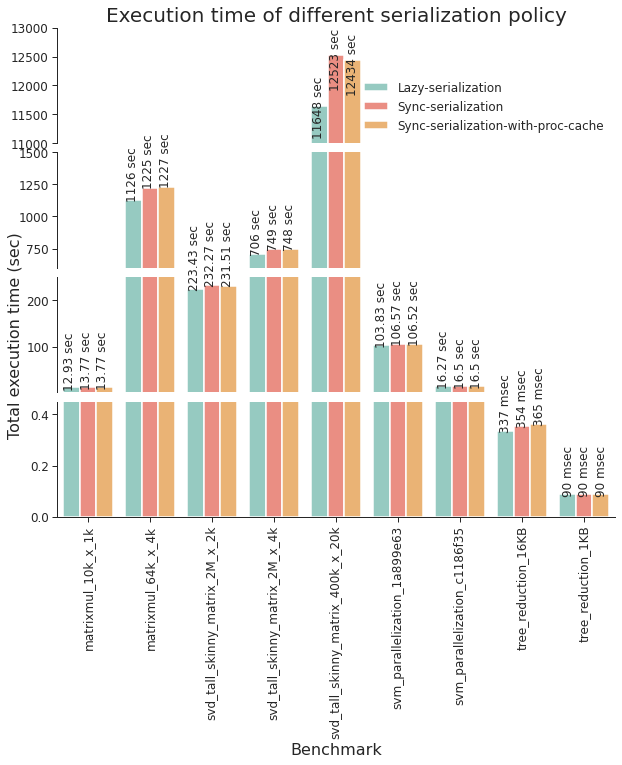

In [573]:
palette = ['#8dd3c7', '#fb8072', '#fdb462']
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10, 9))
sns.barplot(x = 'benchmark', y = 'execution_time', hue='serialization_policy', 
            data = df, ax=ax1, palette = palette)
sns.barplot(x = 'benchmark', y = 'execution_time', hue='serialization_policy', 
            data = df, ax=ax2, palette = palette)
sns.barplot(x = 'benchmark', y = 'execution_time', hue='serialization_policy', 
            data = df, ax=ax3, palette = palette)
sns.barplot(x = 'benchmark', y = 'execution_time', hue='serialization_policy', 
            data = df, ax=ax4, palette = palette)


new_labels = ['Lazy-serialization', 'Sync-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax1.legend(fontsize = 12, loc = 4, frameon=False).texts, new_labels): t.set_text(l)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
ax4.legend().set_visible(False)

fig.subplots_adjust(hspace=0.08)  # adjust space between axes
ax1.set_ylim(11000, 13000)  # outliers only
ax2.set_ylim(600, 1500)  # most of the data
ax3.set_ylim(2, 250)  # most of the data
ax4.set_ylim(0, 0.45)

sns.despine()

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(labeltop=False, bottom=False)  # don't put tick labels at the top
ax2.tick_params(labeltop=False, bottom=False, top=False)  # don't put tick labels at the top
ax3.tick_params(labeltop=False, bottom=False, top=False)  # don't put tick labels at the top
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 90)

ax1.set_xlabel(''); ax1.set_ylabel('');
ax2.set_xlabel(''); ax2.set_ylabel('');
ax3.set_xlabel(''); ax3.set_ylabel('Total execution time (sec)', fontsize=16);
ax4.set_xlabel('Benchmark', fontsize=16); ax4.set_ylabel('');


ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax3.set_axisbelow(True)
ax4.set_axisbelow(True)

for p in ax1.patches:
    if p.get_height() < 11000: continue
    ax1.annotate(f'{int(round(p.get_height(), 0))} sec', (p.get_x() * 1.005, p.get_height() * 0.955), 
                 fontsize=12, rotation=90) 

for p in ax2.patches:
    if p.get_height() > 1500: continue
    ax2.annotate(f'{int(round(p.get_height(), 0))} sec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)

for p in ax3.patches:
    if p.get_height() > 250: continue
    ax3.annotate(f'{round(p.get_height(), 2)} sec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)
   
    
for p in ax4.patches:
    if p.get_height() > 0.5: continue
    ax4.annotate(f'{int(round(p.get_height()*1000, 0))} msec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)


ax1.set_title('Execution time of different serialization policy', fontsize=20); 
plt.show()

### Runtime changes in % for different\n serialization policy relative to Sync-serialization

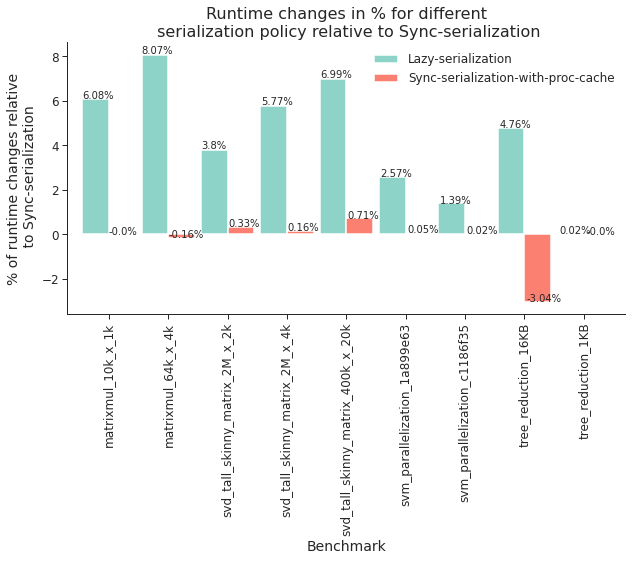

In [574]:
####### The one with the %
dp = df.pivot(index='benchmark', columns='serialization_policy', values='execution_time')

fig, ax = plt.subplots(figsize=(10, 5))

dp['plazy'] = (1 - dp['lazy']/dp['syncwdeser'])*100
dp['psyncnodeser'] = (1 - dp['syncnodeser']/dp['syncwdeser'])*100

dp[['plazy', 'psyncnodeser']].plot.bar(ax=ax, color = palette, width=0.9)
sns.despine()

ax.set_xlabel('Benchmark', fontsize=14);
ax.set_ylabel('% of runtime changes relative\n to Sync-serialization', fontsize=14);

ax.tick_params(axis='both', which='major', labelsize=12)

for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 2)}%', (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=10)


new_labels = ['Lazy-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax.legend(fontsize = 12, frameon=False).texts, new_labels): 
    t.set_text(l)

ax.set_title('Runtime changes in % for different\n serialization policy relative to Sync-serialization', fontsize=16); 
plt.show()


### Total serialization time spent by task for each policy

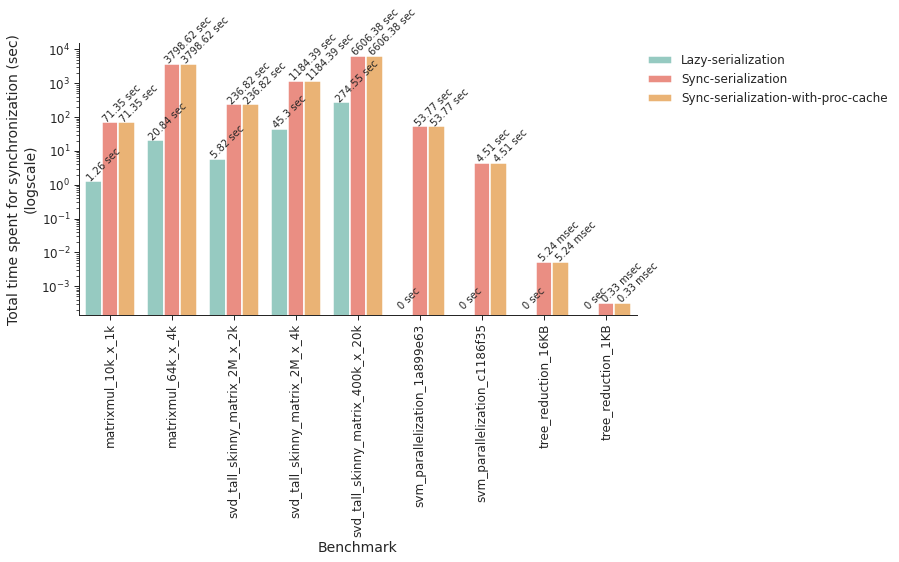

In [575]:
#df.groupby(['benchmark', 'serialization_policy']).agg('describe')['ser_tasktime']

plt_df = dt.groupby(['benchmark', 'serialization_policy']).agg('sum')['ser_delay'].to_frame().reset_index(drop=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine()

sns.barplot(ax=ax, x='benchmark', y='ser_delay', hue='serialization_policy', 
            data=plt_df, palette = palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax.set_yscale('log', base=10)

ax.set_xlabel('Benchmark', fontsize=14);
ax.set_ylabel('Total time spent for synchronization (sec)\n(logscale)', fontsize=14);

ax.tick_params(axis='both', which='major', labelsize=12)

for p in ax.patches:
    if p.get_height() > 0.01:
        ax.annotate(f'{round(p.get_height(), 2)} sec', (p.get_x() * 1.005, p.get_height() * 1.005), 
                fontsize=10, rotation=45) 
    elif not p.get_height():
        ax.annotate(f'0 sec', (p.get_x() * 1.005, 0.0002), 
                fontsize=10, rotation=45)
    elif p.get_height() < 0.01:
        ax.annotate(f'{round(p.get_height()*1000, 2)} msec', (p.get_x() * 1.005, p.get_height() * 1.005), 
                fontsize=10, rotation=45) 

new_labels = ['Lazy-serialization', 'Sync-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax.legend(fontsize = 12, frameon=False, bbox_to_anchor=(1, 1), loc='upper left').texts, new_labels): t.set_text(l)
    

#plt_df

## Task time evaluation
The previous figure compare end to end runtime of the benchmarks. Here, we evaluate a metric called task time. Task time represents the overall time spent by the tasks of the benchmark in the parallel setup and is calculated with $\sum_{i \in tasks}{t_{i}}$. 

### Task time changes relative to Sync-serialization

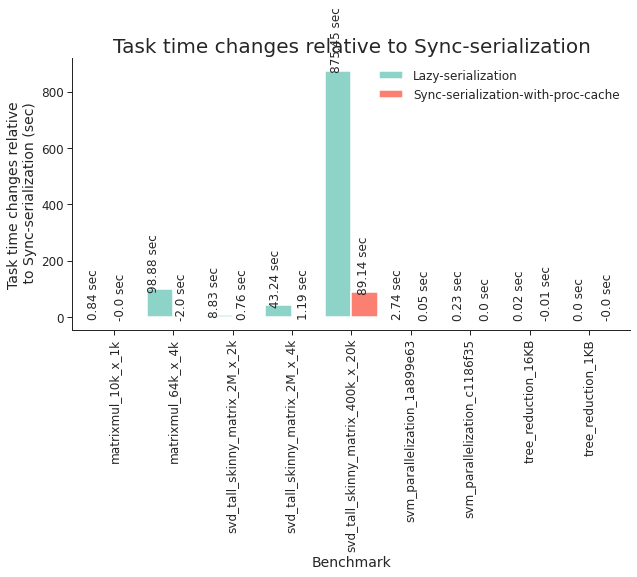

In [576]:
# Task time changes relative to Sync-serialization
fig, ax = plt.subplots(figsize=(10, 5))

dp['rlazy'] = dp['syncwdeser'] - dp['lazy']
dp['rsyncnodeser'] = dp['syncwdeser'] - dp['syncnodeser']

dp[['rlazy', 'rsyncnodeser']].plot.bar(ax=ax, color = palette, width=0.9)
sns.despine()

ax.set_xlabel('Benchmark', fontsize=14);
ax.set_ylabel('Task time changes relative\n to Sync-serialization (sec)', fontsize=14);

ax.tick_params(axis='both', which='major', labelsize=12)

for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 2) if p.get_height() < 3000 else int(round(p.get_height(), 0))} sec', 
                (p.get_x() * 1.025, 
                 p.get_height() * 1.005 if p.get_height() < 3000 else p.get_height() * 0.805), 
                fontsize=12, 
                rotation=90)


new_labels = ['Lazy-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax.legend(fontsize = 12, frameon=False).texts, new_labels): 
    t.set_text(l)

ax.set_title('Task time changes relative to Sync-serialization', fontsize=20); 
plt.show()

### Task time changes in % for different serialization policy relative to Sync-serialization

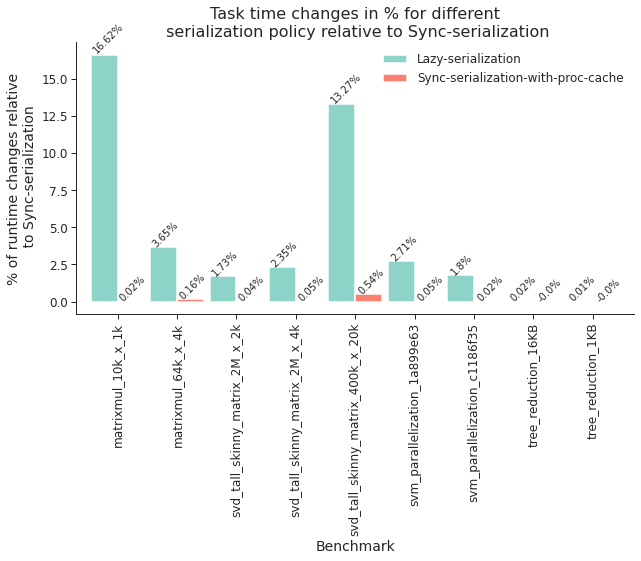

In [577]:
####### The one with the %
dp = df.pivot(index='benchmark', columns='serialization_policy', values='task_time')

fig, ax = plt.subplots(figsize=(10, 5))

dp['plazy'] = (1 - dp['lazy']/dp['syncwdeser'])*100
dp['psyncnodeser'] = (1 - dp['syncnodeser']/dp['syncwdeser'])*100

dp[['plazy', 'psyncnodeser']].plot.bar(ax=ax, color = palette, width=0.9)
sns.despine()

ax.set_xlabel('Benchmark', fontsize=14);
ax.set_ylabel('% of runtime changes relative\n to Sync-serialization', fontsize=14);

ax.tick_params(axis='both', which='major', labelsize=12)

for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 2)}%', (p.get_x() * 1.005, p.get_height() * 1.005), 
                fontsize=10, rotation=45)


new_labels = ['Lazy-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax.legend(fontsize = 12, frameon=False).texts, new_labels): 
    t.set_text(l)

ax.set_title('Task time changes in % for different\n serialization policy relative to Sync-serialization', fontsize=16); 
plt.show()

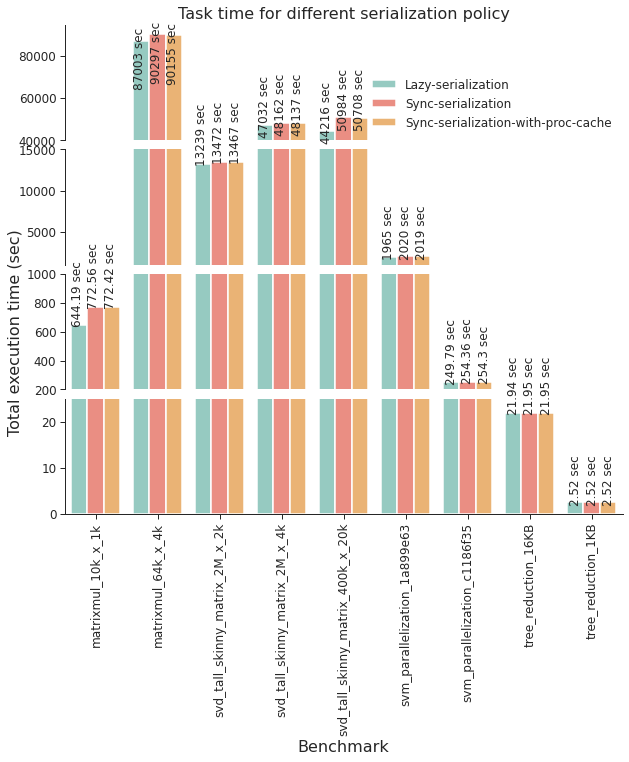

In [578]:
palette = ['#8dd3c7', '#fb8072', '#fdb462']
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10, 9))
sns.barplot(x = 'benchmark', y = 'task_time', hue='serialization_policy', 
            data = df, ax=ax1, palette = palette)
sns.barplot(x = 'benchmark', y = 'task_time', hue='serialization_policy', 
            data = df, ax=ax2, palette = palette)
sns.barplot(x = 'benchmark', y = 'task_time', hue='serialization_policy', 
            data = df, ax=ax3, palette = palette)
sns.barplot(x = 'benchmark', y = 'task_time', hue='serialization_policy', 
            data = df, ax=ax4, palette = palette)


new_labels = ['Lazy-serialization', 'Sync-serialization', 'Sync-serialization-with-proc-cache']
for t, l in zip(ax1.legend(fontsize = 12, loc = 4, frameon=False).texts, new_labels): t.set_text(l)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
ax4.legend().set_visible(False)

fig.subplots_adjust(hspace=0.08)  # adjust space between axes
ax1.set_ylim(bottom = 40000)  # outliers only
ax2.set_ylim(bottom = 1000, top=15000)  # most of the data
ax3.set_ylim(bottom = 200, top=1000)  # most of the data
ax4.set_ylim(0, 25)

sns.despine()

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(labeltop=False, bottom=False)  # don't put tick labels at the top
ax2.tick_params(labeltop=False, bottom=False, top=False)  # don't put tick labels at the top
ax3.tick_params(labeltop=False, bottom=False, top=False)  # don't put tick labels at the top
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 90)

ax1.set_xlabel(''); ax1.set_ylabel('');
ax2.set_xlabel(''); ax2.set_ylabel('');
ax3.set_xlabel(''); ax3.set_ylabel('Total execution time (sec)', fontsize=16);
ax4.set_xlabel('Benchmark', fontsize=16); ax4.set_ylabel('');


ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax3.set_axisbelow(True)
ax4.set_axisbelow(True)

for p in ax1.patches:
    if p.get_height() < 30000: continue
    ax1.annotate(f'{int(round(p.get_height(), 0))} sec', (p.get_x() * 1.005, p.get_height() * 0.755  if p.get_height() > 70000 else p.get_height() * 0.905 ), 
                 fontsize=12, rotation=90) 

for p in ax2.patches:
    if p.get_height() > 15000: continue
    ax2.annotate(f'{int(round(p.get_height(), 0))} sec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)

for p in ax3.patches:
    if p.get_height() > 1000: continue
    ax3.annotate(f'{round(p.get_height(), 2)} sec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)
   
    
for p in ax4.patches:
    if p.get_height() > 25: continue
    ax4.annotate(f'{round(p.get_height(), 2)} sec', (p.get_x() * 1.005, p.get_height() * 1.015), 
                 fontsize=12, rotation=90)


ax1.set_title('Task time for different serialization policy', fontsize=16); 
plt.show()



## Serialization time compare to task time
In all of these experiments, we use chain coloring scheduling policy. To understand the performance improvement of lazy serialization, we looked at the following information:
- First, we see the ratio of local read vs. remote read in different polices,
- Second, we what is the time saved by lazy serialization divided by the total task time. Note, the delay of serialization in the lazy serialization policy is the time we wait for serialization of data that is fetched from a remote node.
- Finally, we see a side by side presentation of the task time and the serialization cost. 

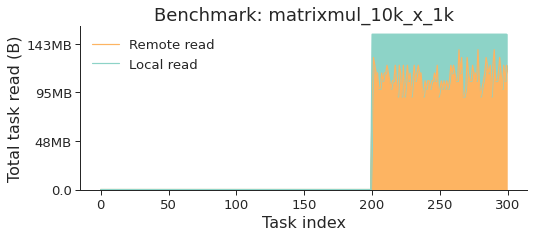

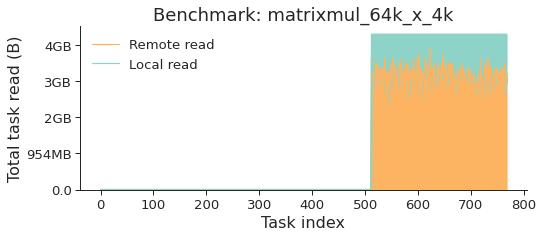

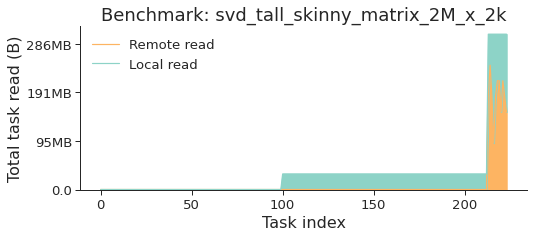

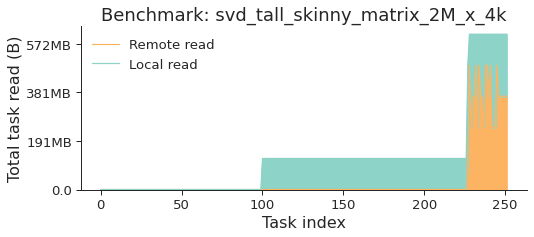

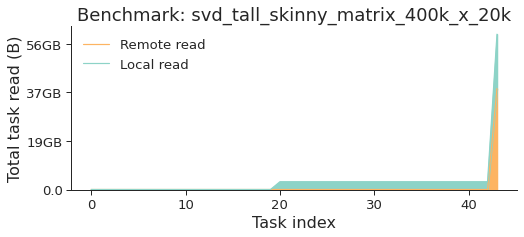

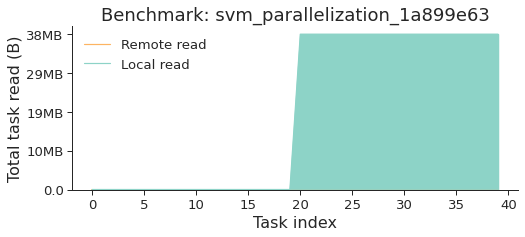

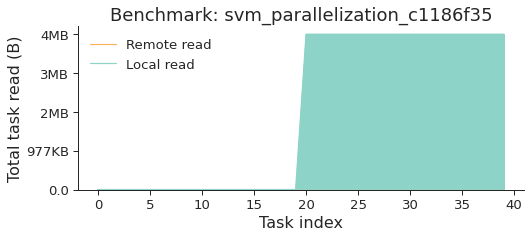

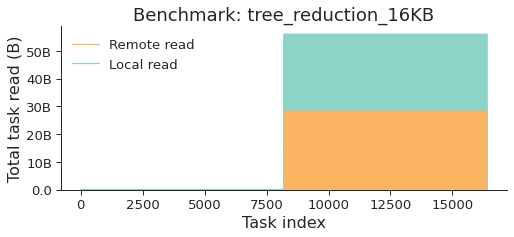

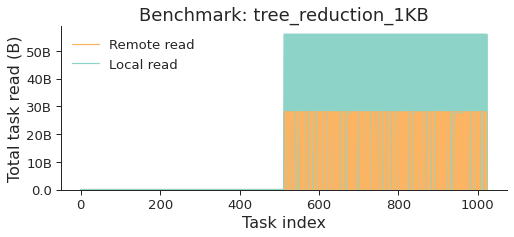

In [613]:
import matplotlib.ticker

def format_yticks(y, pos=None):
    ix = int(y)
    if not ix: return y
    lx = math.log2(ix)
    if lx < 10: return f'{ix}B'
    if lx < 20: return f'{int(round(math.pow(2, lx - 10), 0))}KB'
    if lx < 30: return f'{int(round(math.pow(2, lx - 20), 0))}MB'
    if lx < 40: return f'{int(round(math.pow(2, lx - 30), 0))}GB'
    return y

gdf = dt.groupby('benchmark')

for i1, g1 in gdf:
    g1 = g1.reset_index(drop=True)
    i = 0
    labels = ['Remote read', 'Local read']
    fig, axes = plt.subplots(1, 1, figsize=(8, 3))
    for i2, g2 in g1.groupby('serialization_policy'):
        g2.reset_index(drop=False).sort_values(by='total_read').\
        reset_index(drop = False)[['remote_read', 'local_read']].plot.area(ax=axes, color=[palette[2], palette[0]])
        i += 1
        break
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_yticks))
    axes.legend(labels, frameon=False)
    axes.set_ylabel('Total task read (B)', fontsize=16)
    axes.set_xlabel('Task index', fontsize=16)
    axes.set_title(f'Benchmark: {i1}', fontsize=18)

    #break

### Total Bytes of data accessed by tasks

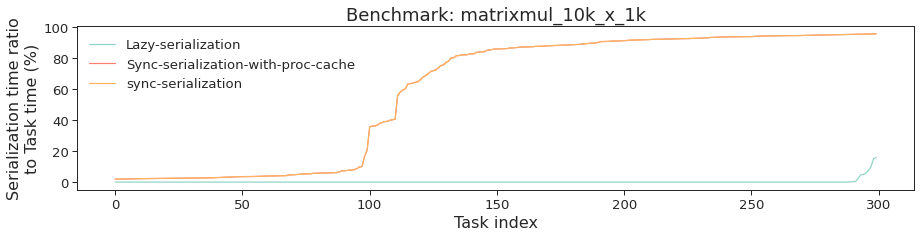

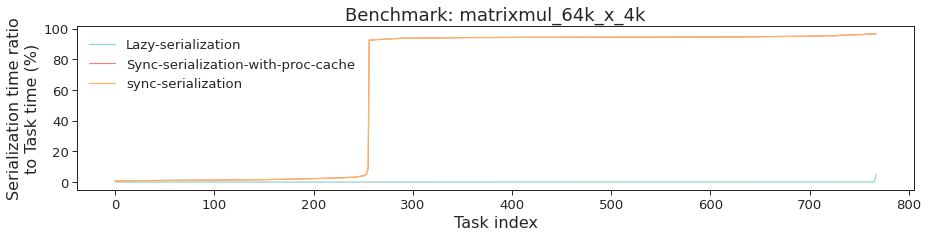

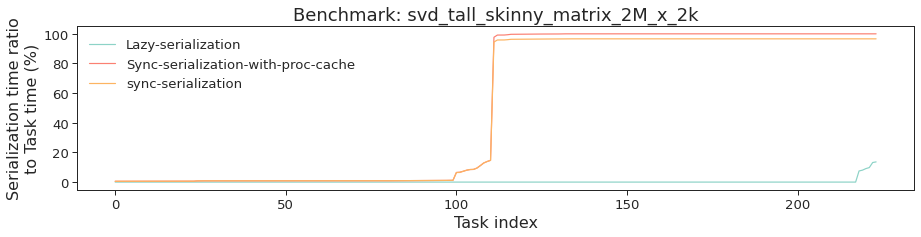

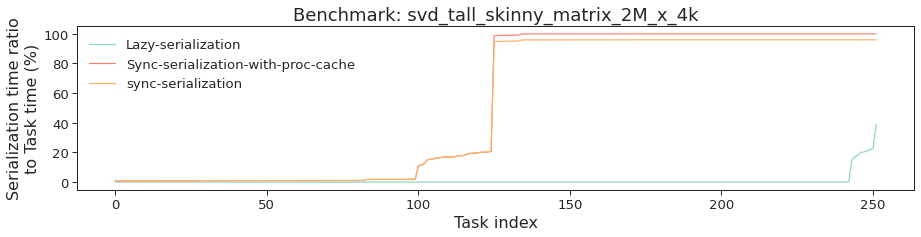

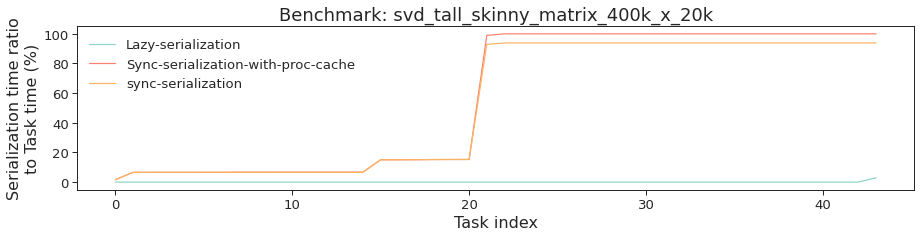

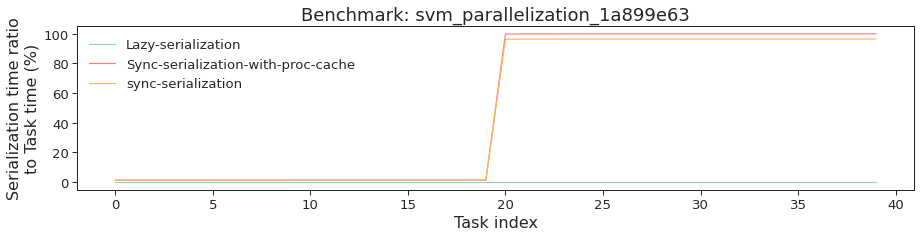

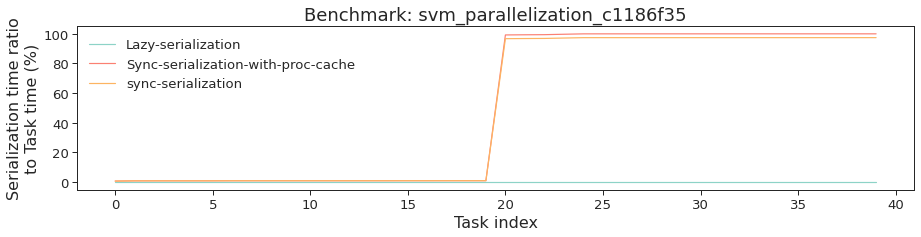

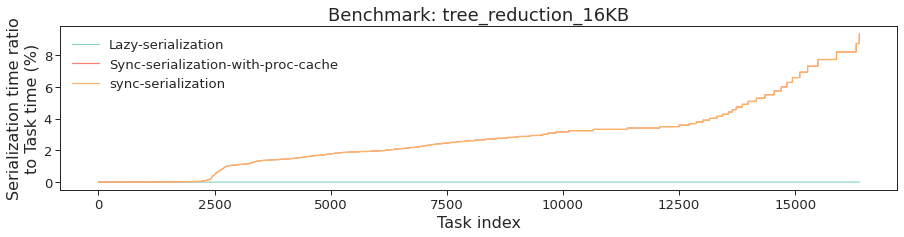

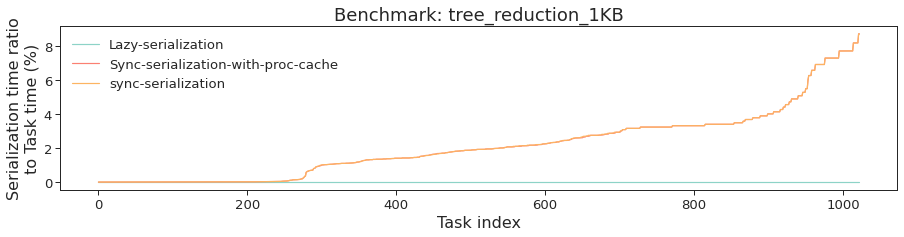

In [622]:
gdf = dt.groupby('benchmark')

for i1, g1 in gdf:
    g1 = g1.reset_index(drop=True)
    i = 0
    labels = []
    fig, axes = plt.subplots(1, 1, figsize=(15, 3))
    for i2, g2 in g1.groupby('serialization_policy'):

        g2.reset_index(drop=False).sort_values(by='total_ser_delay').\
        reset_index(drop = False)['pser_tasktime'].plot(ax=axes, color=palette[i])
        labels.append(policy_name_map[i2])
        i += 1

    axes.legend(labels, frameon=False)
    axes.set_ylabel('Serialization time ratio\n to Task time (%) ', fontsize=16)
    axes.set_xlabel('Task index', fontsize=16)
    axes.set_title(f'Benchmark: {i1}', fontsize=18)
    #break

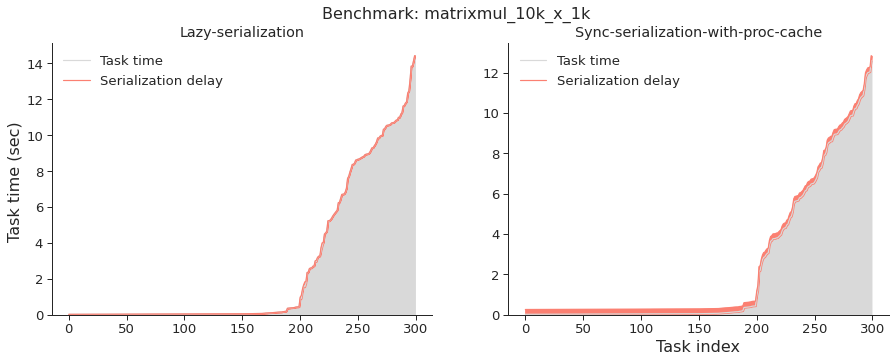

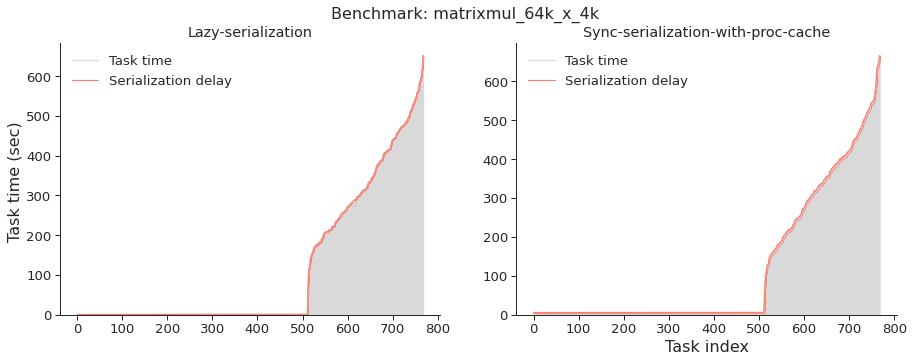

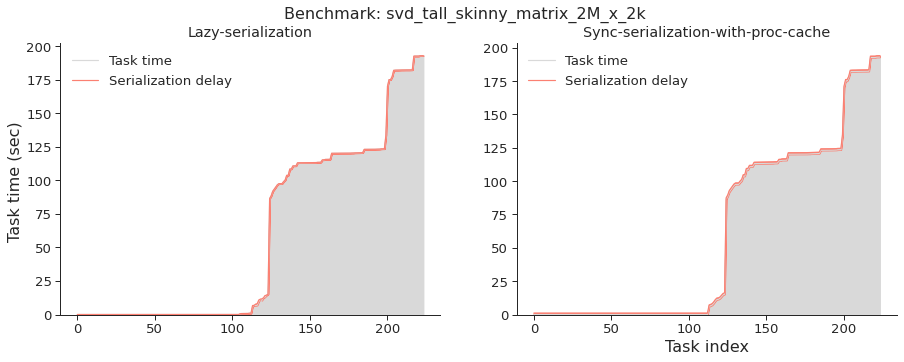

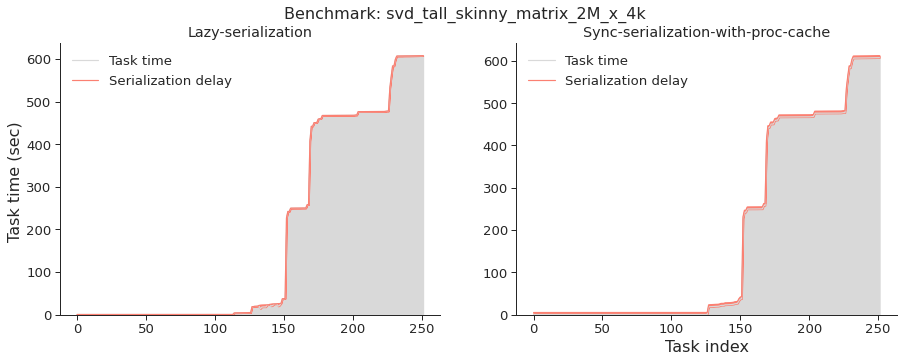

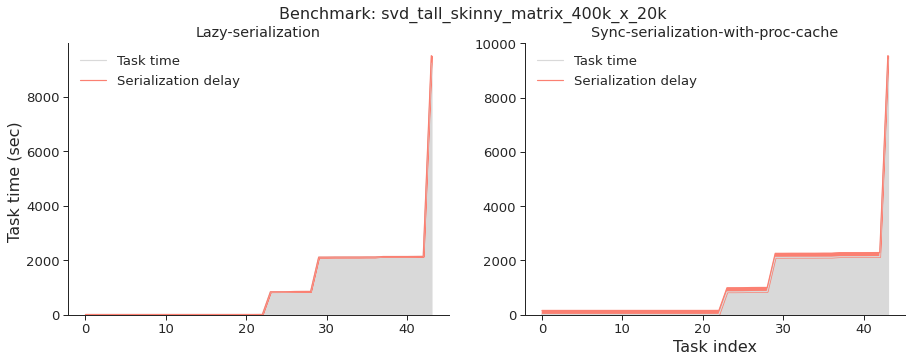

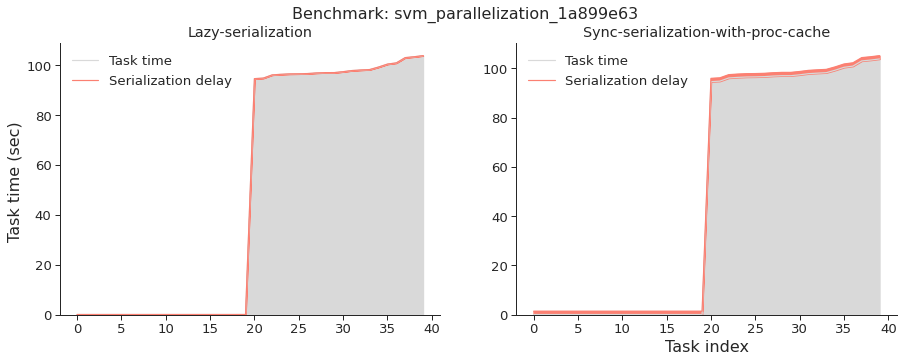

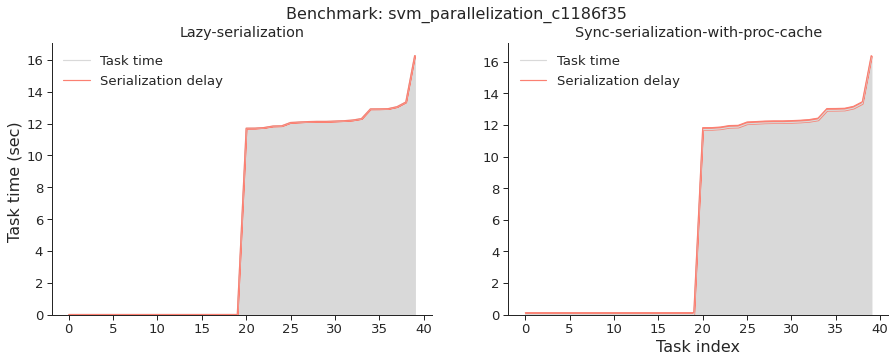

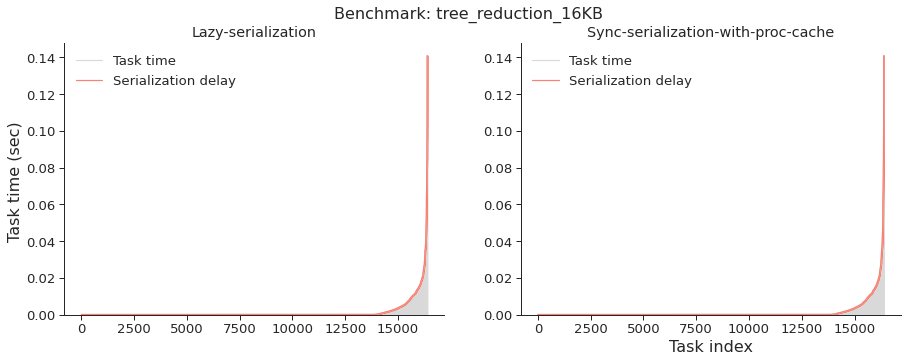

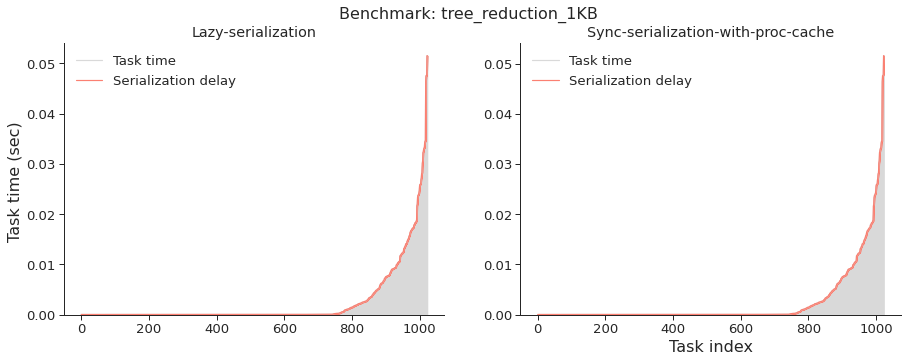

In [621]:
gdf = dt.groupby(['benchmark'])

for i1, g1 in gdf:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    g1 = g1.reset_index(drop=True)
    i = 0
    gp2 = g1.groupby('serialization_policy')
    for i2, g2 in gp2:
        g2.reset_index(drop=False).sort_values(by='task_endtoend_delay').\
        reset_index(drop = False)[['task_no_sertime', 'ser_delay']].plot.area(ax=axes[i], 
                                                                                 color=['#d9d9d9', palette[1]])
        axes[i].set_title(policy_name_map[i2])
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].legend(['Task time', 'Serialization delay'], frameon=False)
        if i == 1:
            break
        i += 1
    axes[0].set_ylabel('Task time (sec) ', fontsize=16)
    axes[1].set_xlabel('Task index', fontsize=16)
    fig.suptitle(f'Benchmark: {i1}', fontsize=16)
    #break
    



## Serialization time and deserialization compare to task time
In all of these experiments, we use chain coloring scheduling policy. To understand the performance improvement of lazy serialization, we looked at the following information:
- First, we see how much time is saved by lazy serialization policy divided by the total task time. Note, the delay of serialization in the lazy serialization policy is the time we wait for serialization of data that is fetched from a remote node.
- Finally, we see a side by side presentation of the task time and the serialization cost (which is the serialization time + de-serialization time). 

In [628]:
dt.columns

Index(['name', 'transfer', 'cpu_time', 'remote_read', 'local_read',
       'fetch_time', 'deserialization_time', 'serialization_time',
       'task_endtoend_delay', 'write', 'wait_for_serialization', 'total_read',
       'ser_delay', 'ser_tasktime', 'pser_tasktime', 'task_no_sertime',
       'deser_tasktime', 'total_ser_delay', 'pserdeser_tasktime', 'benchmark',
       'serialization_policy', 'scheduling_policy'],
      dtype='object')

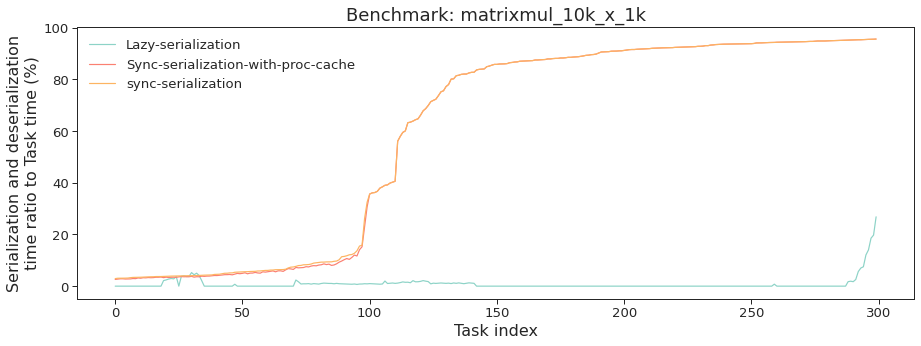

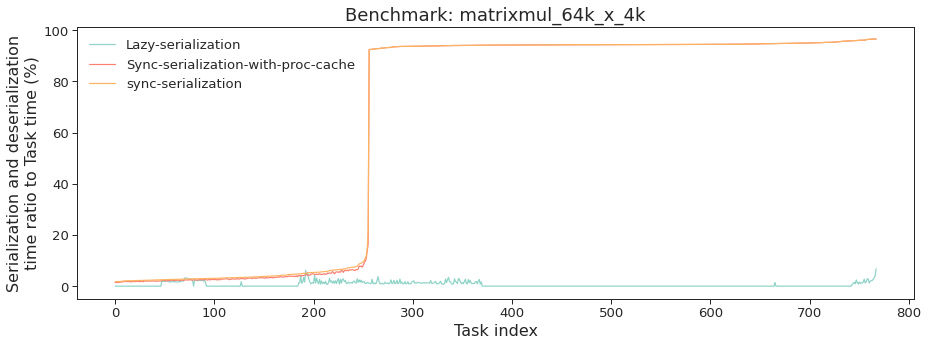

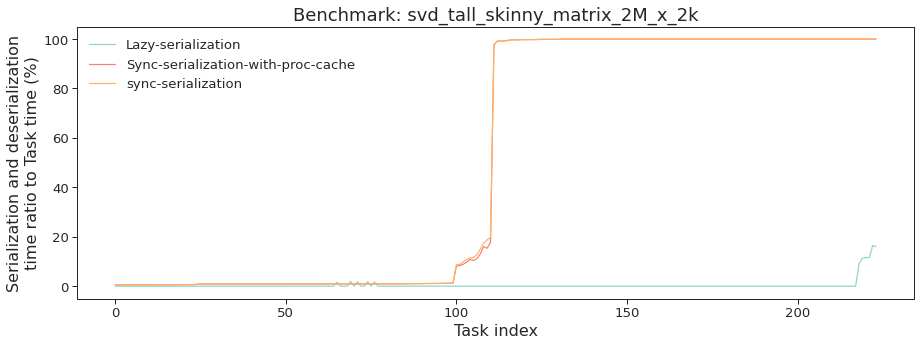

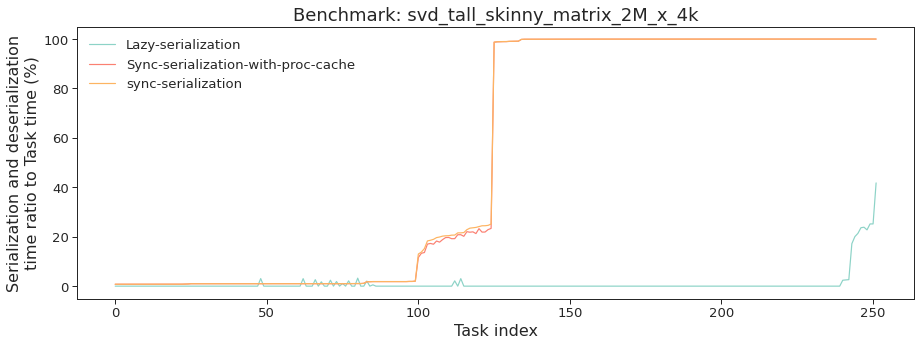

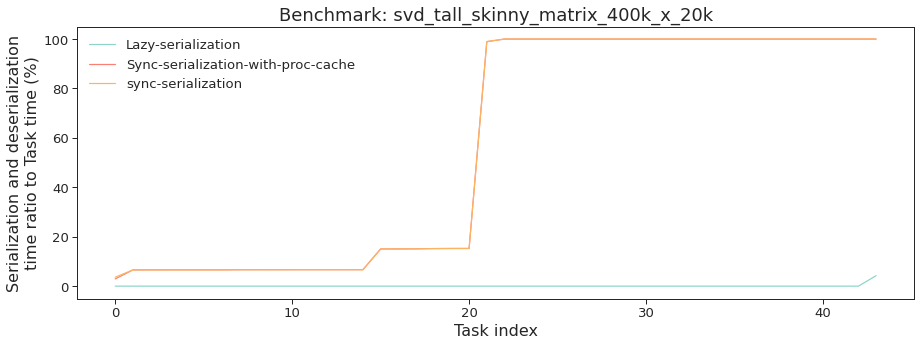

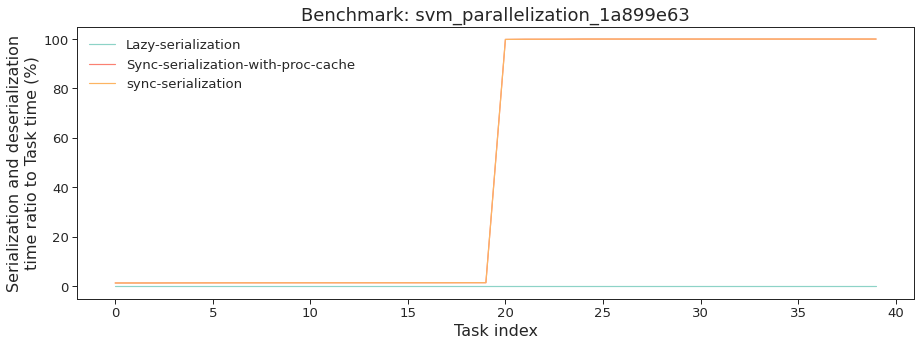

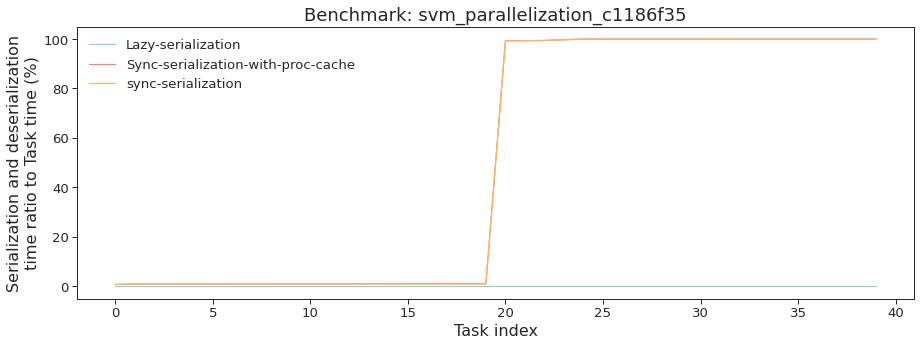

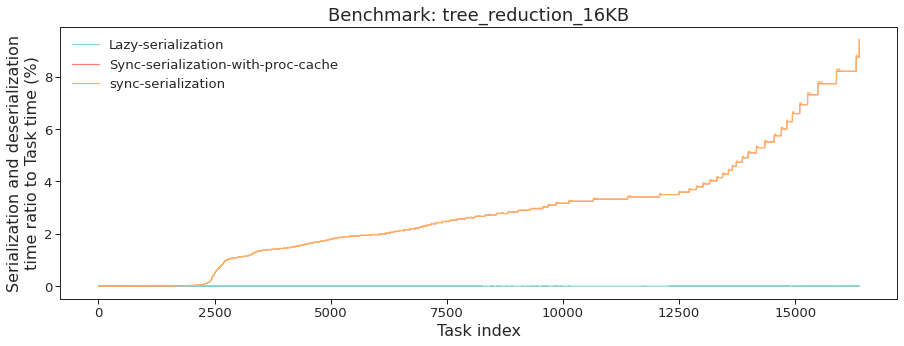

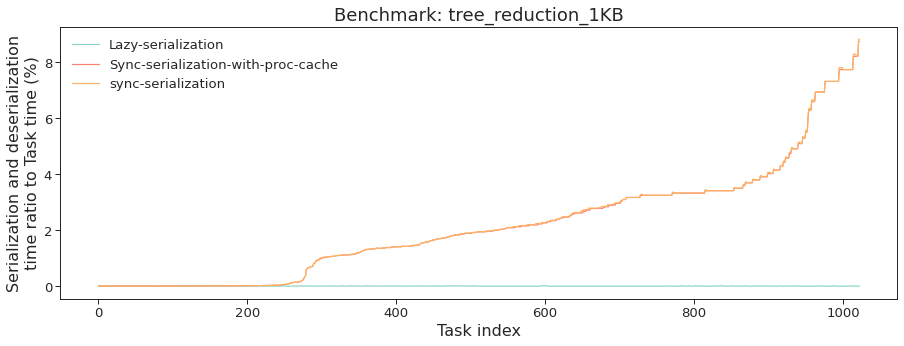

In [631]:
gdf = dt.groupby('benchmark')

for i1, g1 in gdf:
    g1 = g1.reset_index(drop=True)
    i = 0
    labels = []
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    for i2, g2 in g1.groupby('serialization_policy'):

        g2.reset_index(drop=False).sort_values(by='ser_tasktime').\
        reset_index(drop = False)['pserdeser_tasktime'].plot(ax=axes, color=palette[i])
        labels.append(policy_name_map[i2])
        i += 1

    axes.legend(labels, frameon=False)
    axes.set_ylabel('Serialization and deserialization\n time ratio to Task time (%) ', fontsize=16)
    axes.set_xlabel('Task index', fontsize=16)
    axes.set_title(f'Benchmark: {i1}', fontsize=18)
    #break

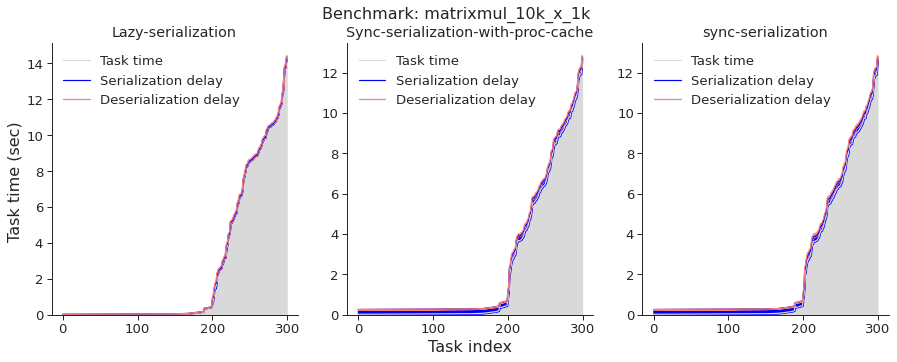

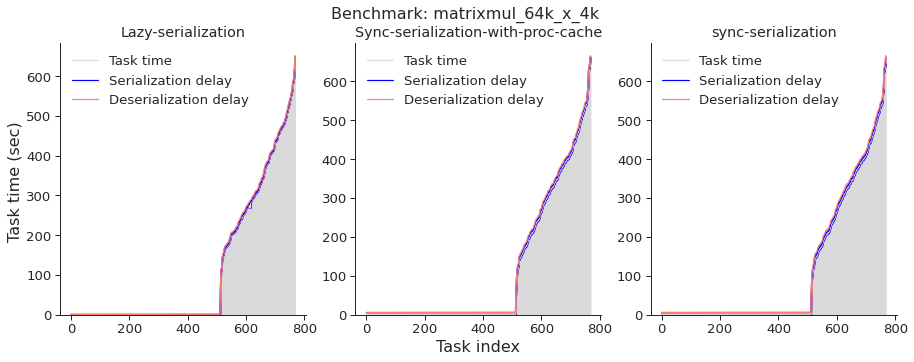

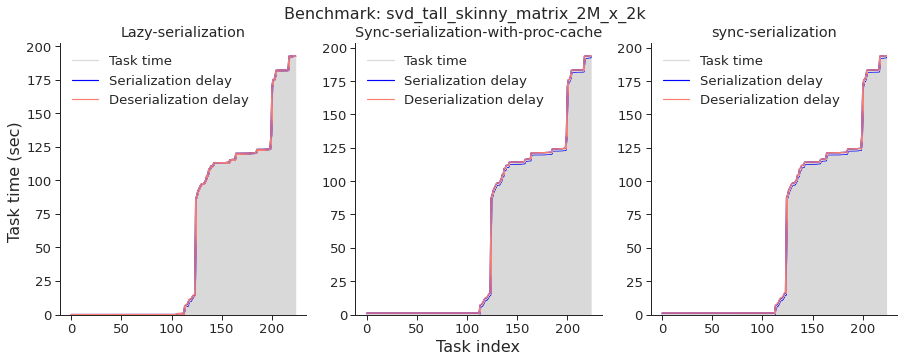

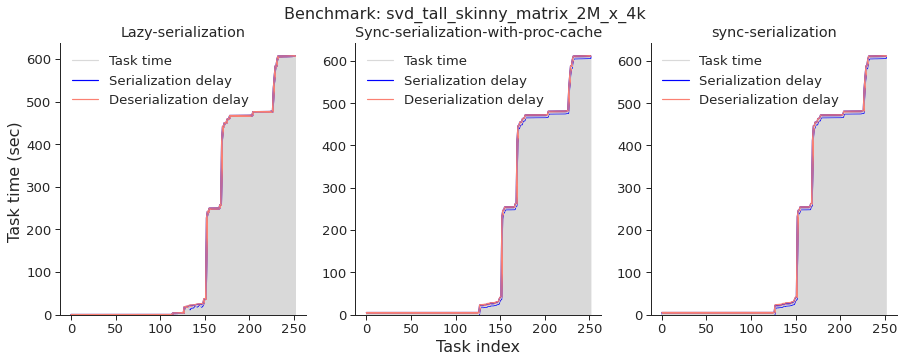

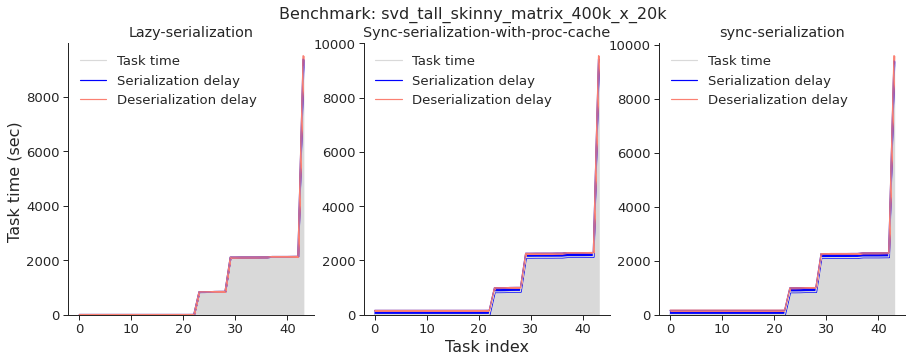

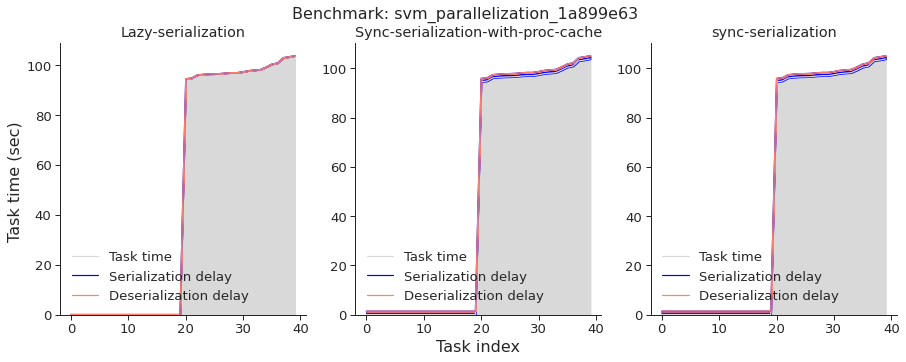

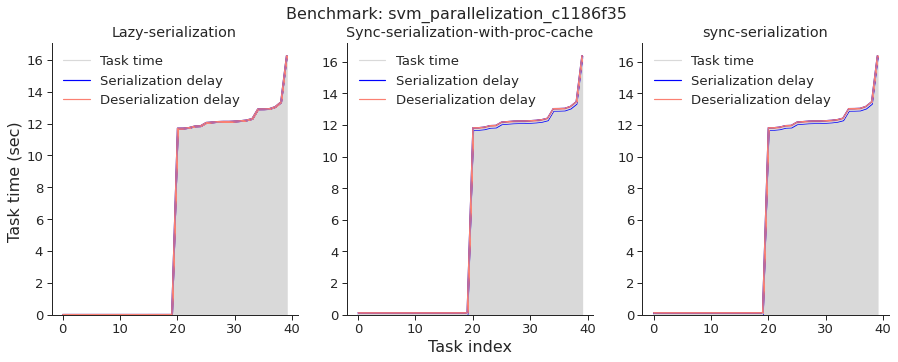

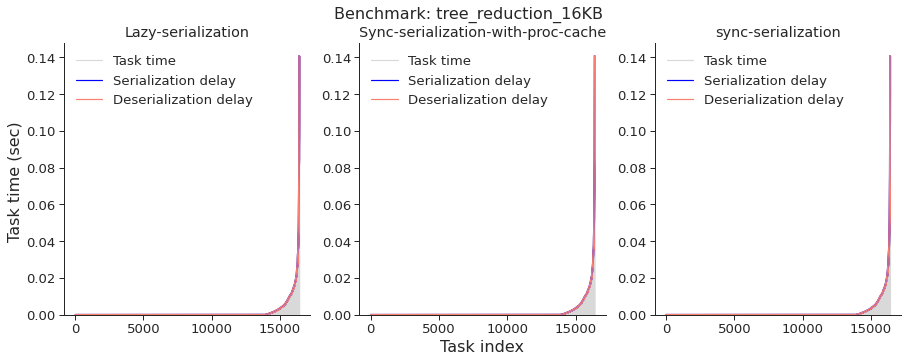

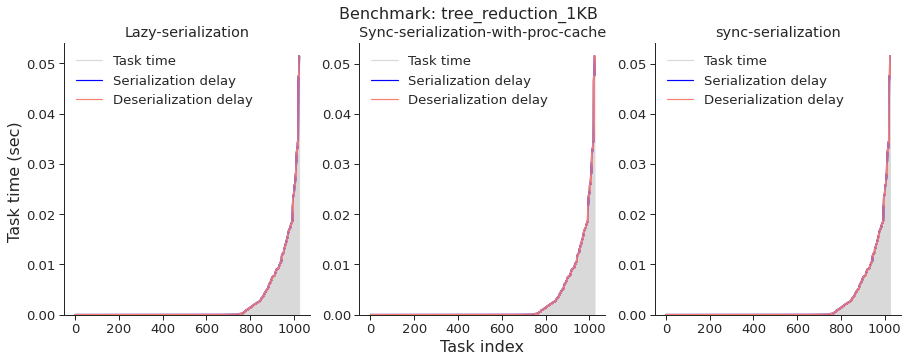

In [637]:
gdf = dt.groupby(['benchmark'])

for i1, g1 in gdf:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    g1 = g1.reset_index(drop=True)
    i = 0
    gp2 = g1.groupby('serialization_policy')
    for i2, g2 in gp2:
        g2.reset_index(drop=False).sort_values(by='task_endtoend_delay').\
        reset_index(drop = False)[['task_no_serdesertime', 'ser_delay', 'deserialization_time']].plot.area(ax=axes[i], 
                                                                                 color=['#d9d9d9', 'blue',
                                                                                        palette[1]])
        axes[i].set_title(policy_name_map[i2])
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].legend(['Task time', 'Serialization delay', 'Deserialization delay'], frameon=False)
        #if i == 1:
        #    break
        i += 1
    axes[0].set_ylabel('Task time (sec) ', fontsize=16)
    axes[1].set_xlabel('Task index', fontsize=16)
    fig.suptitle(f'Benchmark: {i1}', fontsize=16)
    #break

# Conclusion

1. Serialization and deserialization have linear relationship with the size of data. 
2. If the data that is processed by each task (in the parallel setup) is small, the per-task performance improvement achieved via lazy serialization would be decreased.
3. To factors can help us to get better performance from lazy serialization:
   - having tasks that are processing large chunks of data 
   - Most of the data is served from the process memory cache.  